# ***Backtesting ML Based***
* Using backtesting, we just verify how our investment strategy would have performed in the past by applying it to historical data.
* It helps us evaluate the effectiveness, profitability, and risk of our strategy before risking real capital in live markets.
* Backtesting reveals potential risks, such as large drawdowns or periods of underperformance, helping us to refine our strategy.

### ***My Backtesting Includes -***
* Calculating returns for each rebalancing period
* Tracks and compounds these returns over time to see it's change on the portfolio value.
* Give the performance metrics and the necessary visualizations.

In [ ]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Preprocess the price data
def load_price_data(price_file):
    prices = pd.read_csv(price_file)
    prices['date'] = pd.to_datetime(prices['date'])
    prices = prices.sort_values(by=['date']).drop_duplicates(subset=['date', 'symbol'], keep='last')
    return prices.pivot(index='date', columns='symbol', values='close')

In [ ]:
# Calculate daily returns from price data
def calculate_daily_returns(prices):
    return prices.pct_change(fill_method=None).fillna(0)

In [ ]:
# Calculate portfolio returns based on weights and daily returns
def calculate_portfolio_returns(portfolio_weights, daily_returns):
    portfolio_returns = pd.Series(index=daily_returns.index, dtype=float)

    if not pd.api.types.is_datetime64_any_dtype(portfolio_weights['rebalance_date']):
        portfolio_weights['rebalance_date'] = pd.to_datetime(portfolio_weights['rebalance_date'])

    portfolio_weights = portfolio_weights.sort_values('rebalance_date')
    rebalance_dates = portfolio_weights['rebalance_date'].drop_duplicates().sort_values().tolist()
    n = len(rebalance_dates)

    for i, rebalance_date in enumerate(rebalance_dates):
        if i < n - 1:
            next_rebalance = rebalance_dates[i + 1]
            period_mask = (daily_returns.index > rebalance_date) & (daily_returns.index <= next_rebalance)
        else:
            period_mask = (daily_returns.index > rebalance_date)

        period_dates = daily_returns.index[period_mask]
        group = portfolio_weights[portfolio_weights['rebalance_date'] == rebalance_date]
        weights = group.set_index('symbol')['weight']
        valid_stocks = weights.index.intersection(daily_returns.columns)
        weights = weights[valid_stocks]

        if len(valid_stocks) == 0:
            continue

        weights = weights / weights.sum()

        if len(period_dates) > 0:
            returns_slice = daily_returns.loc[period_dates, valid_stocks]
            # Reorder columns to match weights index!
            returns_slice = returns_slice[weights.index]
            period_returns = returns_slice.dot(weights)
            portfolio_returns.loc[period_dates] = period_returns

    return portfolio_returns.dropna()


In [ ]:
# Calculate performance metrics from return series
def calculate_metrics(returns, risk_free_rate=0.0):
    cumulative_returns = (1 + returns).cumprod() - 1
    total_return = cumulative_returns.iloc[-1]
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol if annualized_vol != 0 else np.nan
    cumulative = (1 + returns).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    return {
        'cumulative_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

In [ ]:
# Run full backtest for a portfolio
def run_backtest(portfolio_file, price_file):
    portfolio_weights = pd.read_csv(portfolio_file)
    prices = load_price_data(price_file)
    daily_returns = calculate_daily_returns(prices)
    portfolio_returns = calculate_portfolio_returns(portfolio_weights, daily_returns)
    metrics = calculate_metrics(portfolio_returns)
    return portfolio_returns, metrics

## ***Comparing the Two Strategies***

In [ ]:
equal_returns, equal_metrics = run_backtest(
        '/content/equal_weight_portfolio_ml.csv',
        'daily_adjusted_prices_clean.csv'
)

In [ ]:
risk_adj_returns, risk_adj_metrics = run_backtest(
        '/content/risk_adjusted_portfolio_ml.csv',
        'daily_adjusted_prices_clean.csv'
)

### ***Final Scores for each Strategy***

In [ ]:
metrics_df = pd.DataFrame({
    "Equal Weight": equal_metrics,
    "Risk-Adjusted": risk_adj_metrics
})
metrics_df.T.style.format("{:.2%}")

,cumulative_return,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
Equal Weight,143.93%,28.61%,20.65%,138.55%,-31.97%
Risk-Adjusted,145.57%,28.86%,20.77%,138.94%,-32.07%


## ***Visualizations***

In [ ]:
equal_cumulative_returns = (1 + equal_returns).cumprod() - 1
risk_adj_cumulative_returns = (1 + risk_adj_returns).cumprod() - 1

cumulative_returns_df = pd.DataFrame({
    'Equal Weight Cumulative Returns': equal_cumulative_returns,
    'Risk Adjusted Cumulative Returns': risk_adj_cumulative_returns
})

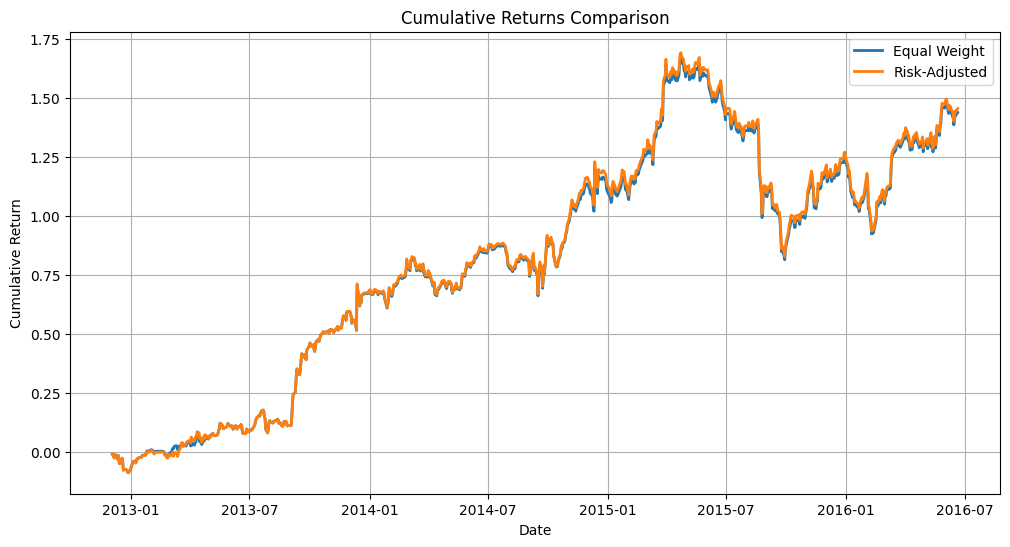

In [ ]:
# Cumulative Returns Comparison
plt.figure(figsize=(12, 6))
plt.plot(equal_cumulative_returns, label='Equal Weight', linewidth=2)
plt.plot(risk_adj_cumulative_returns, label='Risk-Adjusted', linewidth=2)
plt.title('Cumulative Returns Comparison')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

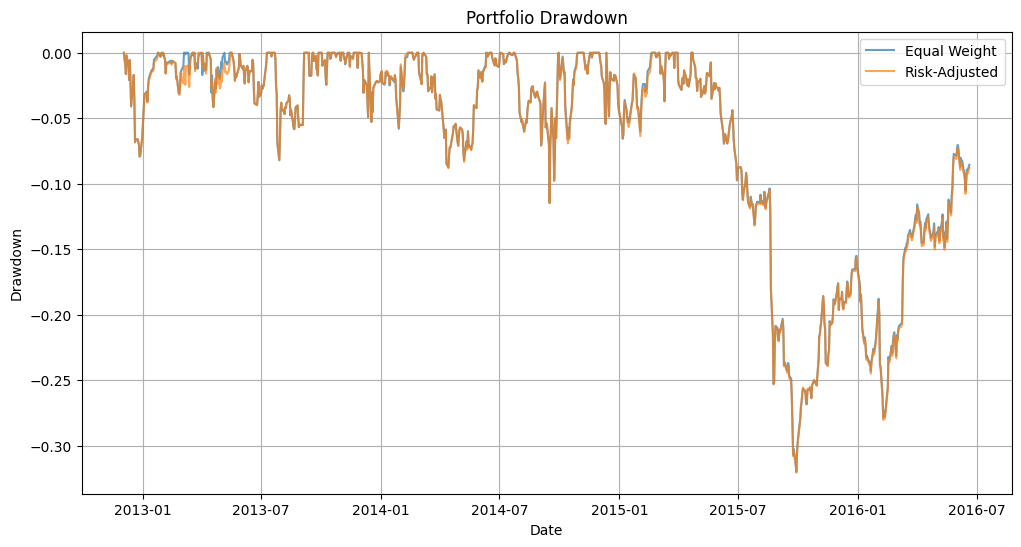

In [ ]:
# Drawdown Analysis
def calculate_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    return (cumulative - peak) / peak

plt.figure(figsize=(12, 6))
plt.plot(calculate_drawdown(equal_returns), label='Equal Weight', alpha=0.7)
plt.plot(calculate_drawdown(risk_adj_returns), label='Risk-Adjusted', alpha=0.7)
plt.title('Portfolio Drawdown')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

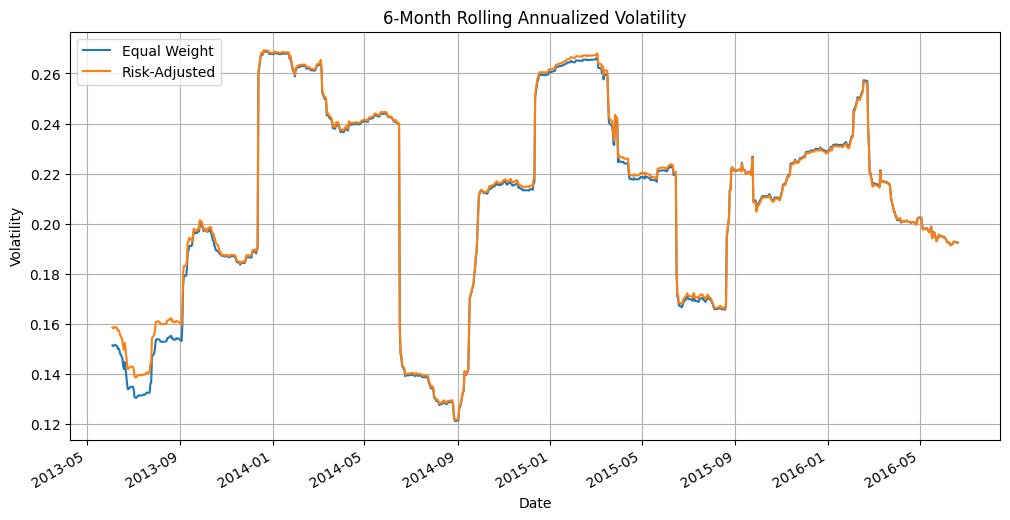

In [ ]:
# Rolling Volatility (6 months)
plt.figure(figsize=(12, 6))
equal_returns.rolling(126).std().mul(np.sqrt(252)).plot(label='Equal Weight')
risk_adj_returns.rolling(126).std().mul(np.sqrt(252)).plot(label='Risk-Adjusted')
plt.title('6-Month Rolling Annualized Volatility')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

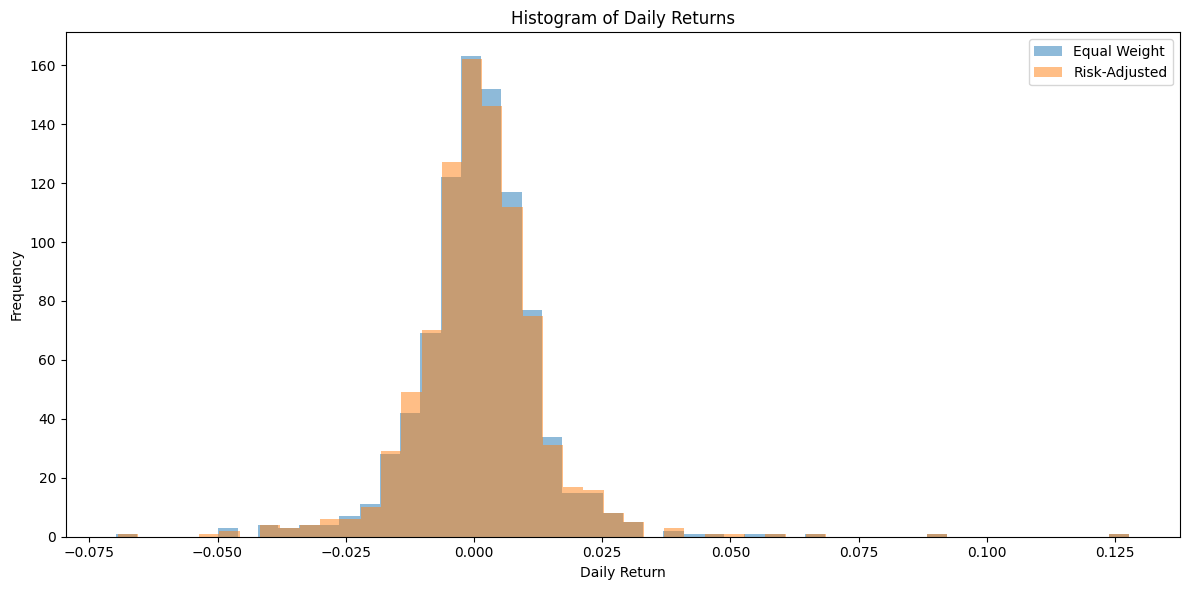

In [ ]:
# Histogram for Daily Returns
def plot_return_histogram(portfolio_returns_dict):
    plt.figure(figsize=(12, 6))
    for label, returns in portfolio_returns_dict.items():
        plt.hist(returns, bins=50, alpha=0.5, label=label)
    plt.title('Histogram of Daily Returns')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

portfolio_returns_dict = {
    'Equal Weight': equal_returns,
    'Risk-Adjusted': risk_adj_returns
}

plot_return_histogram(portfolio_returns_dict)

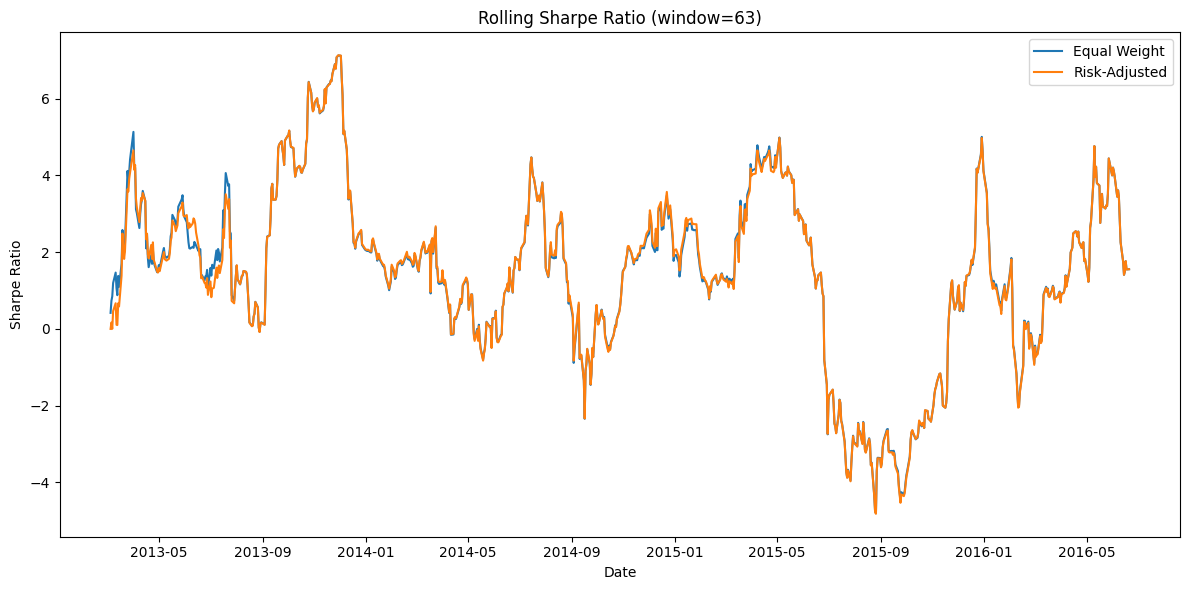

In [ ]:
# Rolling Sharpe Ratio (default: 3 months for daily data).
def plot_rolling_sharpe(portfolio_returns_dict, window=63, risk_free_rate=0.0):
    plt.figure(figsize=(12, 6))
    for label, returns in portfolio_returns_dict.items():
        rolling_mean = returns.rolling(window).mean() * 252
        rolling_std = returns.rolling(window).std() * np.sqrt(252)
        rolling_sharpe = (rolling_mean - risk_free_rate) / rolling_std
        plt.plot(rolling_sharpe, label=label)
    plt.title(f'Rolling Sharpe Ratio (window={window})')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_rolling_sharpe(portfolio_returns_dict)

## ***Benchmark Comparision***
Comparing the portfolio's return with S&P 500 index on Yahoo Finance.
S&P 500 represents the performance of 500 of the largest companies listed on stock exchanges in the United States.



/tmp/ipython-input-12-451589696.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2010-01-01', end='2016-12-31')['Close']
[*********************100%***********************]  1 of 1 completed


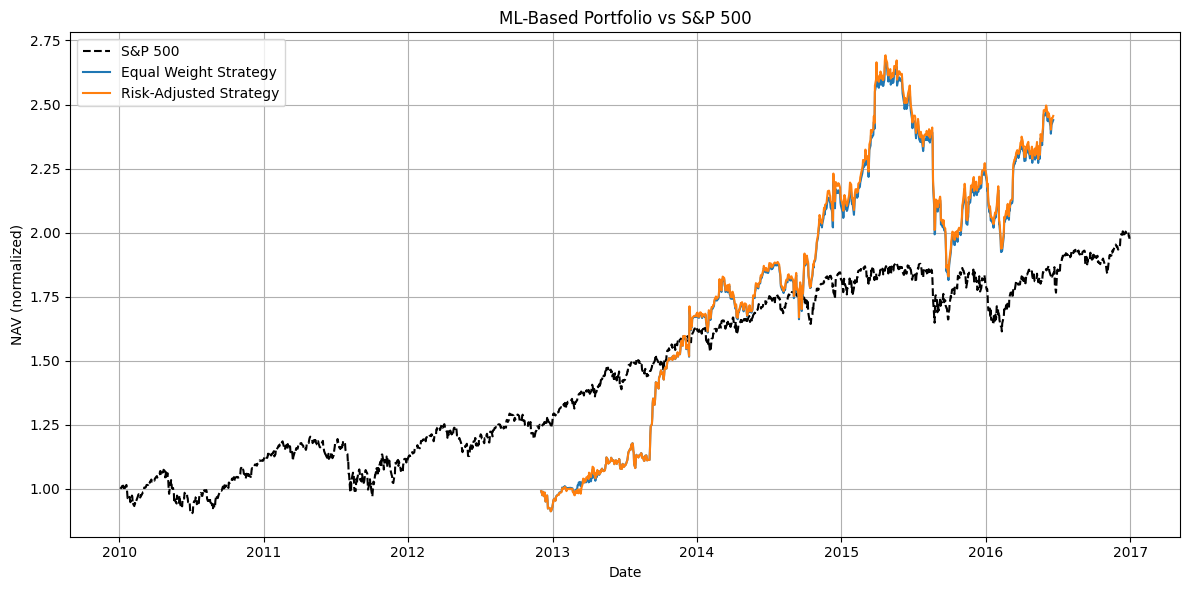

In [12]:
import yfinance as yf

sp500 = yf.download('^GSPC', start='2010-01-01', end='2016-12-31')['Close']
sp500_nav = sp500 / sp500.iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(sp500_nav, label='S&P 500', color='black', linestyle='--')
plt.plot((1 + equal_returns).cumprod(), label='Equal Weight Strategy')
plt.plot((1 + risk_adj_returns).cumprod(), label='Risk-Adjusted Strategy')
plt.title('ML-Based Portfolio vs S&P 500')
plt.ylabel('NAV (normalized)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()